In [1]:
# Cell 1: Imports and Setup
import os
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from skimage import io
import torchvision
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import spectral_norm

import torch
from torch import nn, optim

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Data Loading and Preprocessing

# Define the base directory of your dataset
base_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2"
categories = ['agri', 'barrenland', 'grassland', 'urban']

# Collect all pairs of input (SAR) and output (optical) image paths
input_output_pairs = []
for category in categories:
    input_folder = os.path.join(base_dir, category, 's1')
    output_folder = os.path.join(base_dir, category, 's2')
    
    # Get all input and output image file paths
    input_images = sorted(glob.glob(os.path.join(input_folder, "*.png")))
    output_images = sorted(glob.glob(os.path.join(output_folder, "*.png")))
    
    # Ensure that the number of images match
    assert len(input_images) == len(output_images), \
        f"Number of images in {input_folder} and {output_folder} do not match."
    
    for input_img, output_img in zip(input_images, output_images):
        input_output_pairs.append((input_img, output_img))

# Checking the size of the dataset
print(f"Total dataset size: {len(input_output_pairs)}")

# Shuffle and split the dataset into training and validation sets
np.random.seed(123)  # Seeding for reproducibility
input_output_pairs = np.random.permutation(input_output_pairs)  # Shuffling the pairs

# Splitting into training and validation sets
train_ratio = 0.8
num_total = len(input_output_pairs)
num_train = int(train_ratio * num_total)

train_pairs = input_output_pairs[:num_train]
val_pairs = input_output_pairs[num_train:]

print(f"Training set size: {len(train_pairs)}")
print(f"Validation set size: {len(val_pairs)}")

# Example: Accessing a pair
example_input, example_output = train_pairs[0]
print("Example input image path:", example_input)
print("Example output image path:", example_output)

Total dataset size: 16000
Training set size: 12800
Validation set size: 3200
Example input image path: /kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/grassland/s1/ROIs1970_fall_s1_11_p427.png
Example output image path: /kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/grassland/s2/ROIs1970_fall_s2_11_p427.png


In [3]:
# Cell 3: Utility Functions

# AverageMeter for tracking losses
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

# Function to convert Lab to RGB
def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.  # Denormalize L channel from [-1, 1] to [0, 100]
    ab = ab * 110.  # Denormalize ab channels from [-1, 1] to [-110, 110]
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().detach().numpy()  # Shape: [batch_size, H, W, 3]
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img.astype('float64'))
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

# Visualization function
def visualize(model, data, save=False, epoch=0):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        if i == 0:
            ax.set_title('Input L (SAR)')
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        if i == 0:
            ax.set_title('Generated RGB')
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
        if i == 0:
            ax.set_title('Ground Truth RGB')
    plt.tight_layout()
    if save:
        plt.savefig(f"colorization_epoch_{epoch}.png")
    plt.show()

In [4]:
# Cell 4: Custom Dataset Class

class ColorizationDataset(Dataset):
    def __init__(self, pairs, split='train', transform=None):
        self.pairs = pairs
        self.split = split
        self.size = 256  # Image size
        self.transform = transform

        # Define default transforms if none are provided
        if self.transform is None:
            if self.split == 'train':
                self.transform = transforms.Compose([
                    transforms.Resize((self.size, self.size), Image.BICUBIC),
                    transforms.RandomHorizontalFlip(),
                ])
            else:
                self.transform = transforms.Resize((self.size, self.size), Image.BICUBIC)
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        input_path, output_path = self.pairs[idx]
        
        # Load the input (SAR) image and convert to grayscale
        input_img = Image.open(input_path).convert('L')  # Ensure it's grayscale
        input_img = self.transform(input_img)
        input_img = transforms.ToTensor()(input_img)  # Shape: [1, H, W]
        
        # Load the output (optical) image and convert to RGB
        output_img = Image.open(output_path).convert('RGB')
        output_img = self.transform(output_img)
        output_img = transforms.ToTensor()(output_img)  # Shape: [3, H, W]
        
        # Convert output image from RGB to Lab color space
        output_img_np = output_img.permute(1, 2, 0).numpy()  # Convert to HWC
        output_lab = rgb2lab(output_img_np).astype('float32')
        output_lab = transforms.ToTensor()(output_lab)  # Shape: [3, H, W]
        
        # Normalize L and ab channels
        L = input_img * 2.0 - 1.0  # Normalize L channel to [-1, 1]
        ab = output_lab[1:, ...] / 110.  # Normalize ab channels to [-1, 1]
        
        return {'L': L, 'ab': ab}

In [5]:
# Cell 5: Data Loaders

def make_dataloaders(pairs, batch_size=8, num_workers=4, split='train'):
    dataset = ColorizationDataset(pairs, split=split)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(split=='train'),
        num_workers=num_workers,
        pin_memory=True
    )
    return dataloader

# Create data loaders
batch_size = 8  # Reduced batch size to fit in memory
train_dl = make_dataloaders(train_pairs, batch_size=batch_size, num_workers=4, split='train')
val_dl = make_dataloaders(val_pairs, batch_size=batch_size, num_workers=4, split='val')

In [6]:
# Cell 6: UnetBlock without Self-Attention

class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None:
            input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4, stride=2,
                             padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.5)]
            model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [7]:
# Cell 7: U-Net Generator

class UnetGenerator(nn.Module):
    def __init__(self, input_c=1, output_c=2, num_downs=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(num_downs - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8,
                                   submodule=unet_block, dropout=True)
        unet_block = UnetBlock(num_filters * 4, num_filters * 8,
                               submodule=unet_block)
        unet_block = UnetBlock(num_filters * 2, num_filters * 4,
                               submodule=unet_block)
        unet_block = UnetBlock(num_filters, num_filters * 2,
                               submodule=unet_block)
        self.model = UnetBlock(output_c, num_filters, input_c=input_c,
                               submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

In [8]:
# Cell 8: Discriminator with Spectral Normalization

class PatchDiscriminatorSN(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        layers = [self.get_layers(input_c, num_filters, norm=False)]
        nf_mult = 1
        for n in range(1, n_down):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            layers += [self.get_layers(num_filters * nf_mult_prev,
                                       num_filters * nf_mult, s=2)]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_down, 8)
        layers += [self.get_layers(num_filters * nf_mult_prev,
                                   num_filters * nf_mult, s=1)]
        layers += [spectral_norm(nn.Conv2d(num_filters * nf_mult, 1,
                                           kernel_size=4, stride=1, padding=1))]
        self.model = nn.Sequential(*layers)

    def get_layers(self, in_c, out_c, k=4, s=2, p=1, norm=True):
        layers = [spectral_norm(nn.Conv2d(in_c, out_c, kernel_size=k,
                                          stride=s, padding=p))]
        if norm:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [9]:
# Cell 9: GAN Loss

class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        labels = self.real_label if target_is_real else self.fake_label
        return labels.expand_as(preds)

    def forward(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [10]:
# # Cell 10: Perceptual Loss

# class PerceptualLoss(nn.Module):
#     def __init__(self, feature_layers=[0, 5, 10, 19, 28], weights=[1.0]*5):
#         super(PerceptualLoss, self).__init__()
#         vgg_weights = VGG16_Weights.DEFAULT
#         self.vgg = vgg16(weights=vgg_weights).features[:max(feature_layers)+1].to(device).eval()
#         for param in self.vgg.parameters():
#             param.requires_grad = False
#         self.feature_layers = feature_layers
#         self.weights = weights

#     def forward(self, pred, target):
#         # Since the predicted and target images are ab channels, we need to create 3-channel images
#         # We'll concatenate the L channel with the ab channels to form Lab images, then convert to RGB
#         # For perceptual loss, we need RGB images with 3 channels

#         # Reconstruct Lab images
#         L = torch.zeros_like(pred[:, :1, :, :]).to(device)  # Dummy L channel
#         pred_lab = torch.cat([L, pred], dim=1)
#         target_lab = torch.cat([L, target], dim=1)

#         # Convert Lab to RGB
#         pred_rgb = lab_to_rgb(L, pred)
#         target_rgb = lab_to_rgb(L, target)

#         # Convert to tensors
#         pred_rgb = torch.from_numpy(pred_rgb).permute(0, 3, 1, 2).to(device).float()
#         target_rgb = torch.from_numpy(target_rgb).permute(0, 3, 1, 2).to(device).float()

#         # Normalize RGB images to [-1, 1]
#         pred_rgb = (pred_rgb / 0.5) - 1.0
#         target_rgb = (target_rgb / 0.5) - 1.0

#         loss = 0.0
#         x = pred_rgb
#         y = target_rgb
#         for i, layer in enumerate(self.vgg):
#             x = layer(x)
#             y = layer(y)
#             if i in self.feature_layers:
#                 loss += self.weights[self.feature_layers.index(i)] * nn.functional.l1_loss(x, y)
#         return loss

In [11]:
# Cell 11: Model Initialization

def init_weights(net, init='kaiming'):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and ('Conv' in classname or 'Linear' in classname):
            if init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init == 'normal':
                nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_func)
    return net

def init_model(model):
    model = model.to(device)
    model = init_weights(model)
    return model

In [12]:
# Cell 12: MainModel Class

class MainModel(nn.Module):
    def __init__(self, net_G=None, net_D=None, lr_G=2e-4, lr_D=2e-4,
                 lambda_L1=100., lambda_perceptual=10.):
        super().__init__()
        self.device = device
        self.lambda_L1 = lambda_L1
        # self.lambda_perceptual = lambda_perceptual

        if net_G is None:
            self.net_G = init_model(UnetGenerator(input_c=1, output_c=2))
        else:
            self.net_G = net_G.to(self.device)

        if net_D is None:
            self.net_D = init_model(PatchDiscriminatorSN(input_c=3))
        else:
            self.net_D = net_D.to(self.device)

        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        # self.perceptual_loss = PerceptualLoss()

        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G,
                                betas=(0.5, 0.999))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D,
                                betas=(0.5, 0.999))

    def setup_input(self, data):
        self.L = data['L'].to(self.device)  # Input SAR image
        self.ab = data['ab'].to(self.device)  # Ground truth ab channels

    def forward(self):
        self.fake_color = self.net_G(self.L)  # Generate fake ab channels

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)  # Concatenate L and fake ab
        real_image = torch.cat([self.L, self.ab], dim=1)  # Concatenate L and real ab

        fake_preds = self.net_D(fake_image.detach())
        real_preds = self.net_D(real_image)

        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)

        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        # self.loss_G_perceptual = self.perceptual_loss(self.fake_color, self.ab) * self.lambda_perceptual

        self.loss_G = self.loss_G_GAN + self.loss_G_L1  # + self.loss_G_perceptual
        self.loss_G.backward()

    def optimize(self):
        # Update Discriminator
        self.forward()
        self.net_D.train()
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        # Update Generator
        self.net_G.train()
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [13]:
# Cell 13: Pretraining the Generator

def pretrain_generator(net_G, train_dl, criterion, optimizer, epochs):
    net_G.train()
    for epoch in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L = data['L'].to(device)
            ab = data['ab'].to(device)

            preds = net_G(L)
            loss = criterion(preds, ab)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Pretraining Epoch [{epoch+1}/{epochs}], Loss: {loss_meter.avg:.5f}")

In [14]:
# def train_model(model, train_dl, val_dl, epochs, pretrain_epochs=5, display_every=5):
#     # Pretrain Generator
#     print("Starting Generator Pretraining...")
#     pretrain_generator(
#         net_G=model.module.net_G,
#         train_dl=train_dl,
#         criterion=model.module.L1criterion,
#         optimizer=model.module.opt_G,
#         epochs=pretrain_epochs
#     )
#     print("Pretraining Completed.\n")

#     # Training with GAN
#     for epoch in range(epochs):
#         model.module.net_G.train()
#         model.module.net_D.train()
#         loss_meter_dict = {'loss_D': AverageMeter(), 'loss_G': AverageMeter()}
#         for data in tqdm(train_dl):
#             model.module.setup_input(data)
#             model.module.optimize()

#             # Update loss meters
#             loss_meter_dict['loss_D'].update(model.module.loss_D.item(), data['L'].size(0))
#             loss_meter_dict['loss_G'].update(model.module.loss_G.item(), data['L'].size(0))

#         # Validation and Visualization
#         if (epoch + 1) % display_every == 0:
#             print(f"\nEpoch [{epoch+1}/{epochs}]")
#             print(f"Loss_D: {loss_meter_dict['loss_D'].avg:.5f}, "
#                   f"Loss_G: {loss_meter_dict['loss_G'].avg:.5f}")
#             data = next(iter(val_dl))
#             visualize(model.module, data, save=True, epoch=epoch+1)
#             torch.save(model.module.state_dict(), f'model_epoch_{epoch+1}.pth')

In [15]:
def train_model(model, train_dl, val_dl, epochs, pretrain_epochs=5, display_every=5):
    device = model.module.device  # Get device from MainModel

    # Pretrain Generator
    print("Starting Generator Pretraining...")
    pretrain_generator(
        net_G=model.module.net_G,
        train_dl=train_dl,
        criterion=model.module.L1criterion,
        optimizer=model.module.opt_G,  # Fixed 'opt' argument
        epochs=pretrain_epochs
    )
    print("Pretraining Completed.\n")

    # Training with GAN
    for epoch in range(epochs):
        model.module.net_G.train()
        model.module.net_D.train()
        loss_meter_dict = {'loss_D': AverageMeter(), 'loss_G': AverageMeter(), 'per_pixel_acc': AverageMeter()}  # Added per-pixel accuracy

        for data in tqdm(train_dl):
            model.module.setup_input(data)
            model.module.optimize()

            # Update loss meters
            loss_meter_dict['loss_D'].update(model.module.loss_D.item(), data['L'].size(0))
            loss_meter_dict['loss_G'].update(model.module.loss_G.item(), data['L'].size(0))

        # Validation and Per-Pixel Accuracy Calculation
        if (epoch + 1) % display_every == 0:
            model.module.net_G.eval()
            with torch.no_grad():
                val_data = next(iter(val_dl))
                L = val_data['L'].to(device)
                ab_gt = val_data['ab'].to(device)

                ab_pred = model.module.net_G(L)  # Get predictions

                # Compute per-pixel accuracy
                threshold = 0.05  # Define tolerance for color difference
                correct_pixels = torch.abs(ab_pred - ab_gt) < threshold
                per_pixel_accuracy = correct_pixels.float().mean().item()

                loss_meter_dict['per_pixel_acc'].update(per_pixel_accuracy, L.size(0))

            # Print losses and accuracy
            print(f"\nEpoch [{epoch+1}/{epochs}]")
            print(f"Loss_D: {loss_meter_dict['loss_D'].avg:.5f}, "
                  f"Loss_G: {loss_meter_dict['loss_G'].avg:.5f}, "
                  f"Per-Pixel Accuracy: {loss_meter_dict['per_pixel_acc'].avg:.5f}")

            # Save Model and Visualize
            visualize(model.module, val_data, save=True, epoch=epoch+1)
            torch.save(model.module.state_dict(), f'model_epoch_{epoch+1}.pth')


Starting Generator Pretraining...


100%|██████████| 1600/1600 [01:59<00:00, 13.36it/s]


Pretraining Epoch [1/5], Loss: 0.19624


100%|██████████| 1600/1600 [01:58<00:00, 13.53it/s]


Pretraining Epoch [2/5], Loss: 0.11657


100%|██████████| 1600/1600 [01:58<00:00, 13.54it/s]


Pretraining Epoch [3/5], Loss: 0.10005


100%|██████████| 1600/1600 [01:58<00:00, 13.54it/s]


Pretraining Epoch [4/5], Loss: 0.09628


100%|██████████| 1600/1600 [01:58<00:00, 13.54it/s]


Pretraining Epoch [5/5], Loss: 0.08732
Pretraining Completed.



100%|██████████| 1600/1600 [04:33<00:00,  5.86it/s]



Epoch [5/20]
Loss_D: 0.01961, Loss_G: 16.80188, Per-Pixel Accuracy: 0.47360


<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img.astype('float64'))
<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img.astype('float64'))
<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img.astype('float64'))
<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 11 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img.astype('float64'))
<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  img_r

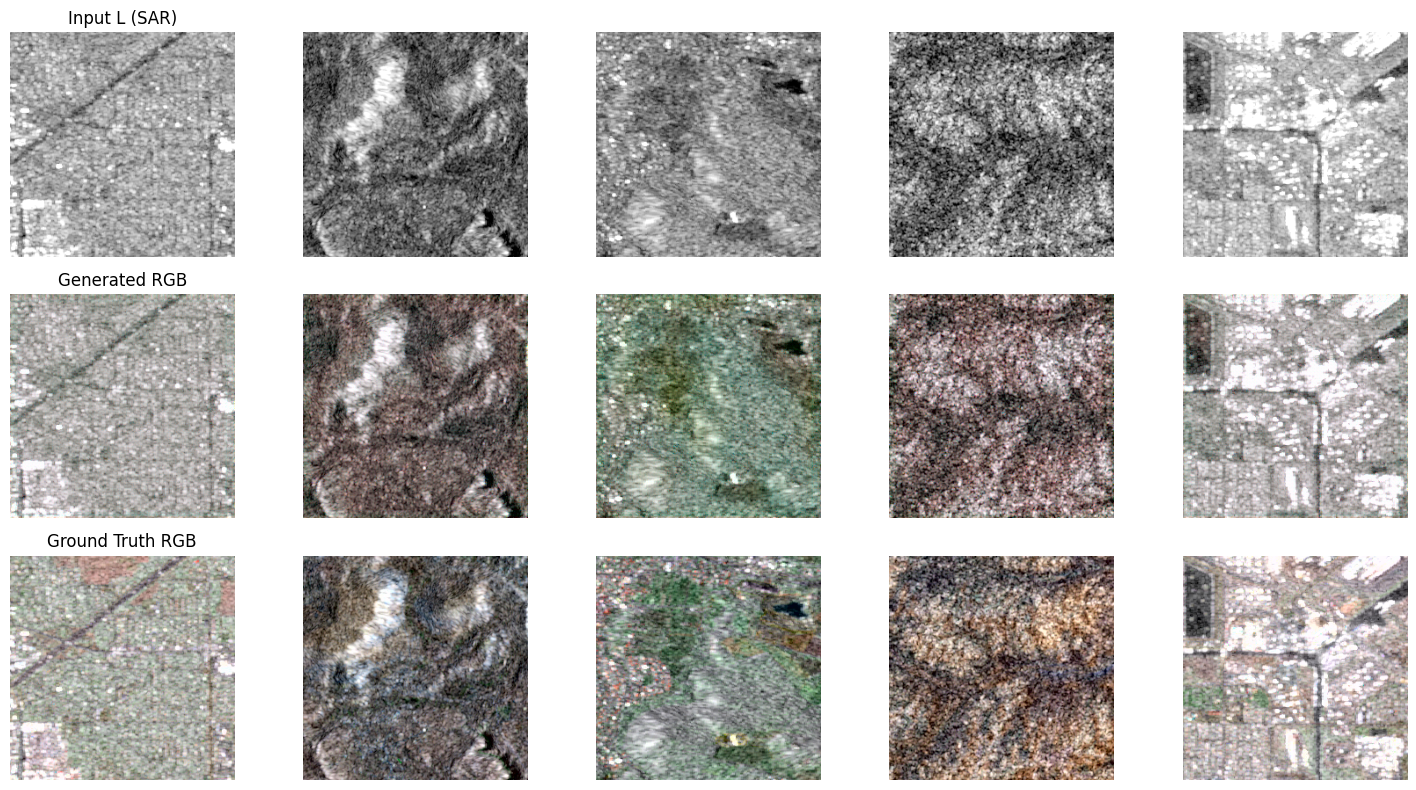

100%|██████████| 1600/1600 [04:32<00:00,  5.86it/s]



Epoch [10/20]
Loss_D: 0.06381, Loss_G: 15.66526, Per-Pixel Accuracy: 0.33517


<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 171 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img.astype('float64'))
<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 45 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img.astype('float64'))
<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 103 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img.astype('float64'))
<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 10 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img.astype('float64'))
<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 205 negative Z values that have been clipped to zero


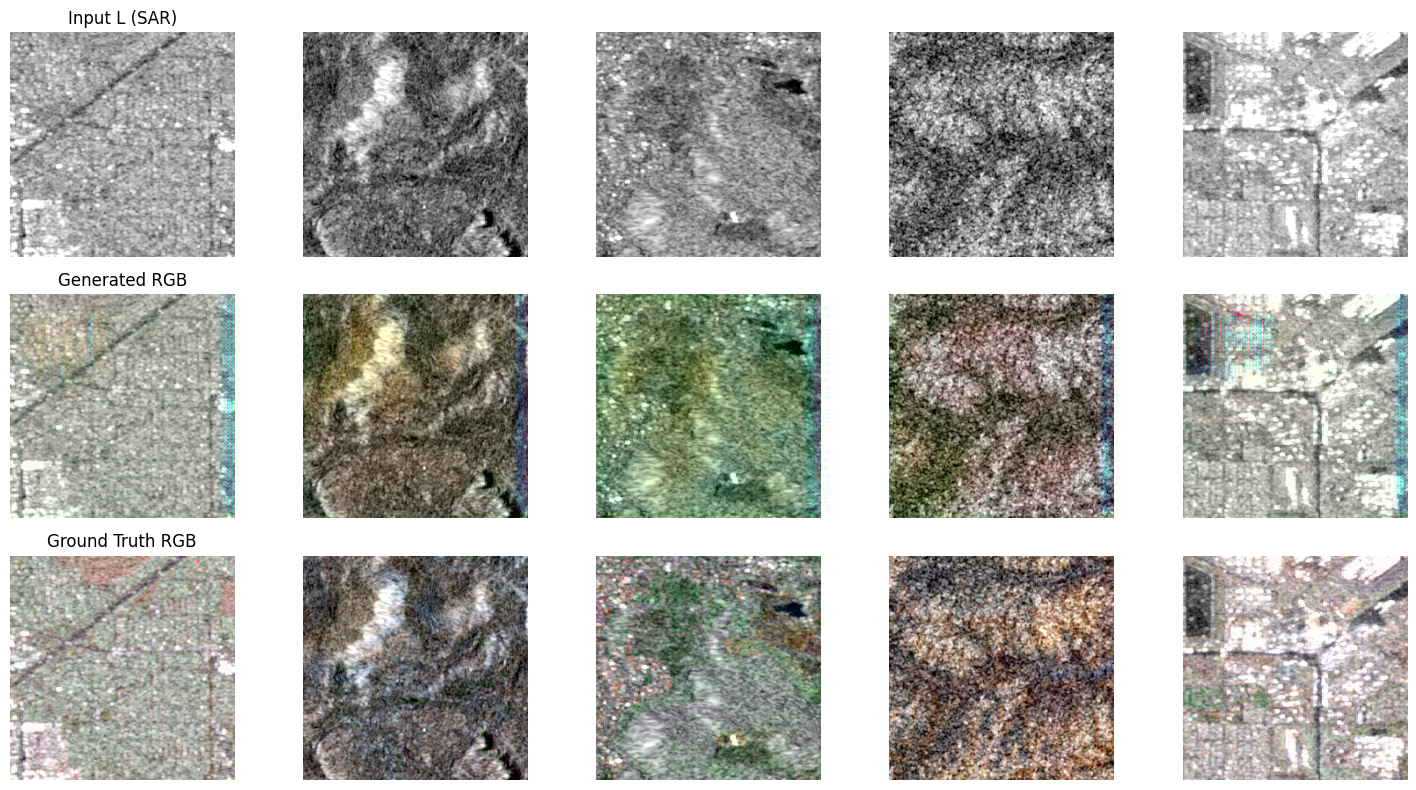

100%|██████████| 1600/1600 [04:32<00:00,  5.86it/s]



Epoch [15/20]
Loss_D: 0.00056, Loss_G: 17.00619, Per-Pixel Accuracy: 0.42865


<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 96 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img.astype('float64'))
<ipython-input-3-0d444e07a62b>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 139 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img.astype('float64'))


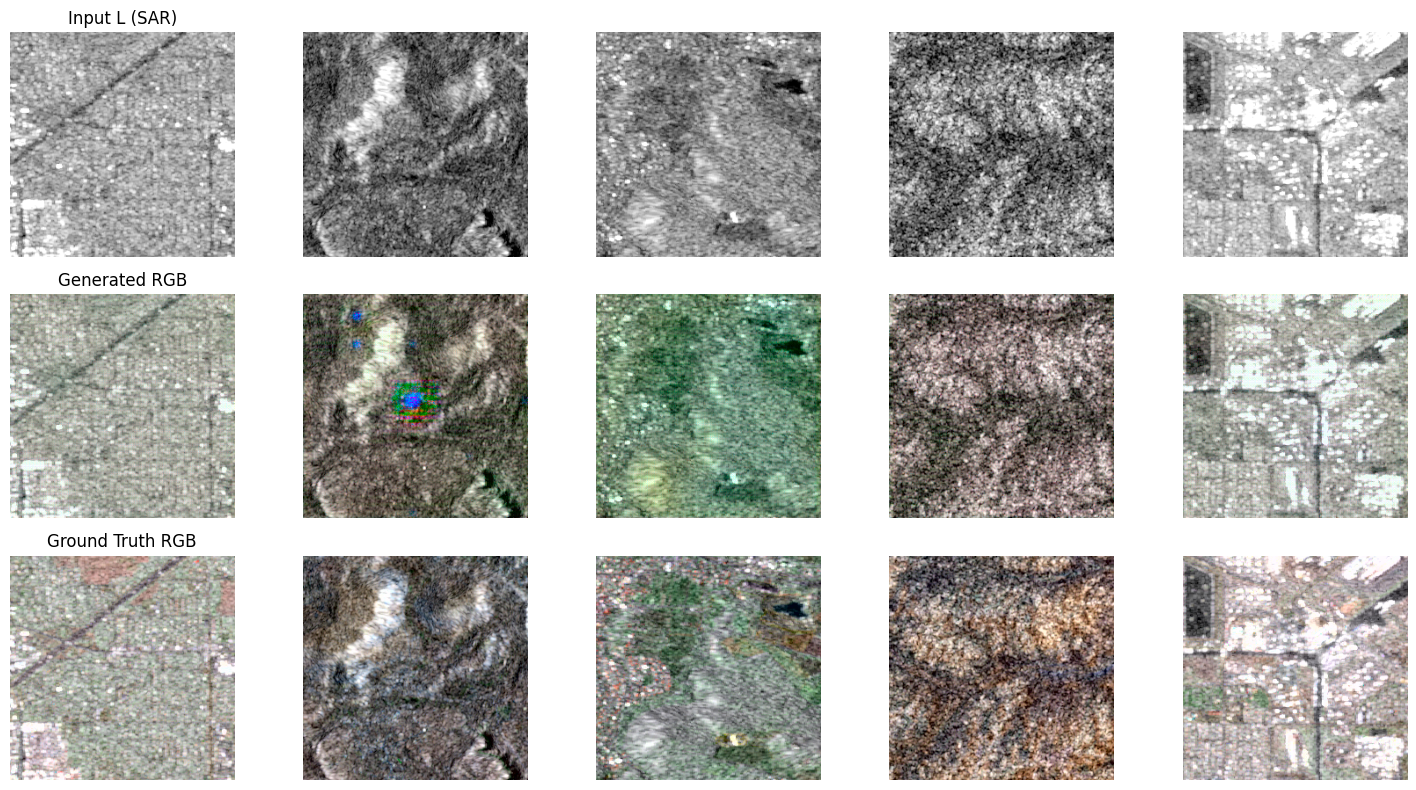

100%|██████████| 1600/1600 [04:32<00:00,  5.86it/s]



Epoch [20/20]
Loss_D: 0.01337, Loss_G: 16.28725, Per-Pixel Accuracy: 0.40687


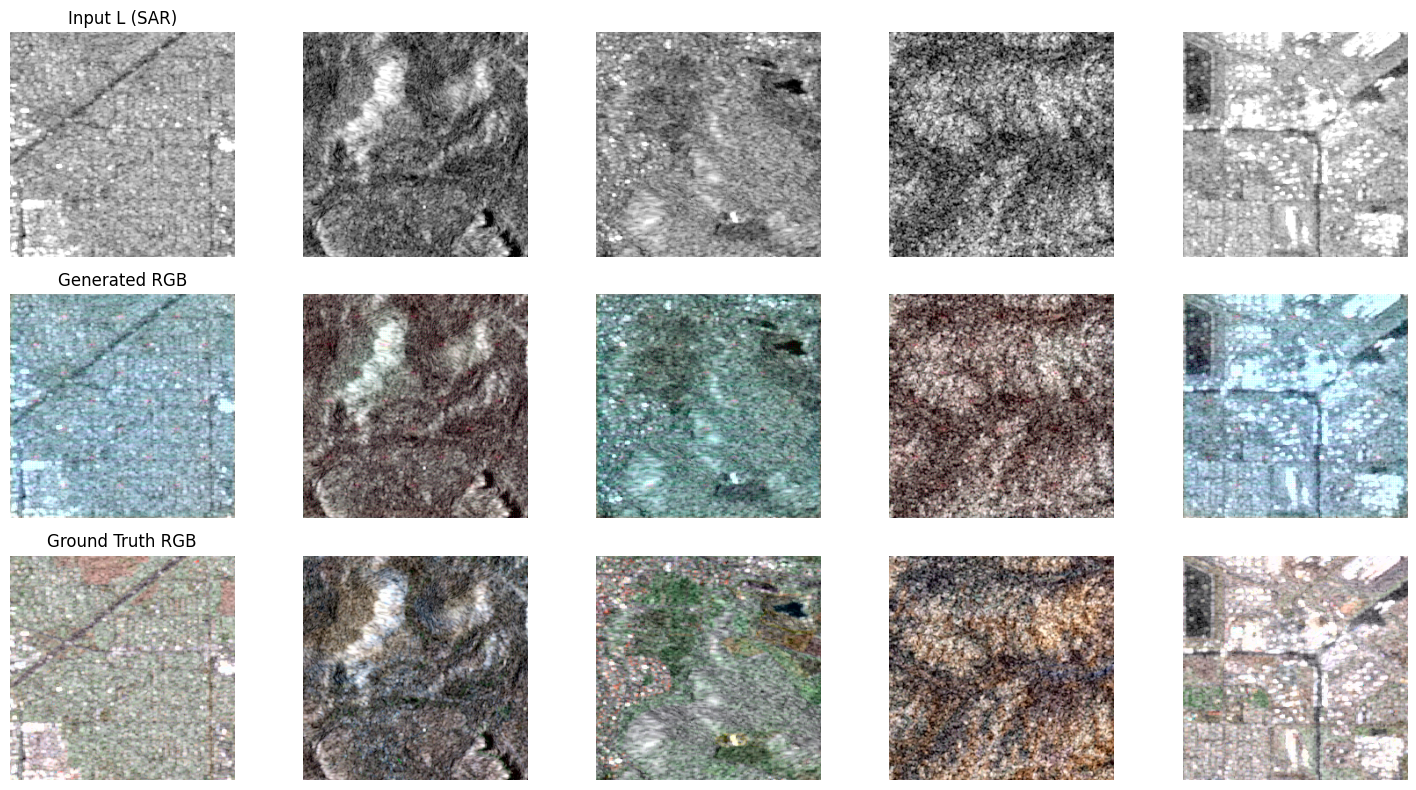

In [16]:
# Initialize the model
model = MainModel()

# Wrap the model with DataParallel
model = nn.DataParallel(model)

# Training parameters
pretrain_epochs = 5
gan_epochs = 20
total_epochs = gan_epochs

# Start training
train_model(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=total_epochs,
    pretrain_epochs=pretrain_epochs,
    display_every=5
)